# 7.1 Processing raw data
This section combines the raw data, the adjustments and cleaned bars to get processed 1-minute data. There are no gaps for processed data. All stocks that are active on a certain day have minute bars for every minute, from pre to post market, even if no trades took place. Empty bars are forward filled. Only for the first day, backwards filling may be done. All processed data will have the following columns: <code>['open', 'high', 'low', 'close', 'close_original', 'turnover', 'tradeable']</code>. Turnover is the dollar amount the stock has traded and is volume * close. Volume is an useless number on its own, as 1000 volume for a $200k stock is not the same as with a $0.1 stock. The 'close_original' is the unadjusted price. This is needed for filtering, e.g. only the stocks above $1.

The steps:
1. The bars are split and dividend adjusted. (Split adjustment is done first, then dividend adjustment. Polygon already gives the adjusted dividends, so there is no need to split-adjust dividends.)
2. After this, the data is forward filled. If there are still NA values, the data is backward filled. Forward/backward filled bars are flagged by setting <code>tradeable</code> to False.
3. The true start/end dates are determined for each stock.

To make the loop more readable, we will first build the functions <code>split_adjust</code>, <code>dividend_adjust</code> and <code>detect_halts</code>.

In [2]:
from tickers import get_tickers
from times import get_market_calendar
from datetime import datetime, date, time
import mplfinance as mpf
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
DATA_PATH = "../data/polygon/"

# 7.2 Split adjustment

In [3]:
adjustments = pd.read_csv(DATA_PATH + f"raw/adjustments/TSLA.csv", parse_dates=True, index_col=0)
bars = pd.read_parquet(DATA_PATH + f"raw/m1/TSLA.parquet")

adjustments.index = pd.to_datetime(adjustments.index).date
splits = adjustments[adjustments.type == "SPLIT"].copy()

In [4]:
splits

,type,subtype,amount
2020-08-31,SPLIT,N,0.200000
2022-08-25,SPLIT,N,0.333333


In [5]:
trading_dates_ticker = sorted(list(set(bars.index.date)))

# The original dates of 'split' are the dates of the split. But adjustments are for all dates before the split.
splits['cumulative_adjustment'] = splits['amount'][::-1].cumprod()
splits = splits.drop(columns=['type', 'subtype', 'amount'])
splits

,cumulative_adjustment
2020-08-31,0.066667
2022-08-25,0.333333


In [6]:
splits.index = splits.index.map(lambda day : max(d for d in trading_dates_ticker if d < day)) # Shift dates 1 day back (the reason we cannot just use timedelta(days=1) is because that might not be a trading date.
splits

,cumulative_adjustment
2020-08-28,0.066667
2022-08-24,0.333333


In [7]:
splits = splits.reindex(trading_dates_ticker) # Reindex using stock data 
splits.cumulative_adjustment = splits.cumulative_adjustment.fillna(method='bfill').fillna(value=1) # Backward fill and fill ones

C:\Users\Nathan\AppData\Local\Temp\ipykernel_17184\2799965111.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  splits.cumulative_adjustment = splits.cumulative_adjustment.fillna(method='bfill').fillna(value=1) # Backward fill and fill ones


In [8]:
splits[splits.index > date(2019, 3, 26)][:5]

,cumulative_adjustment
2019-03-27,0.066667
2019-03-28,0.066667
2019-03-29,0.066667
2019-04-01,0.066667
2019-04-02,0.066667


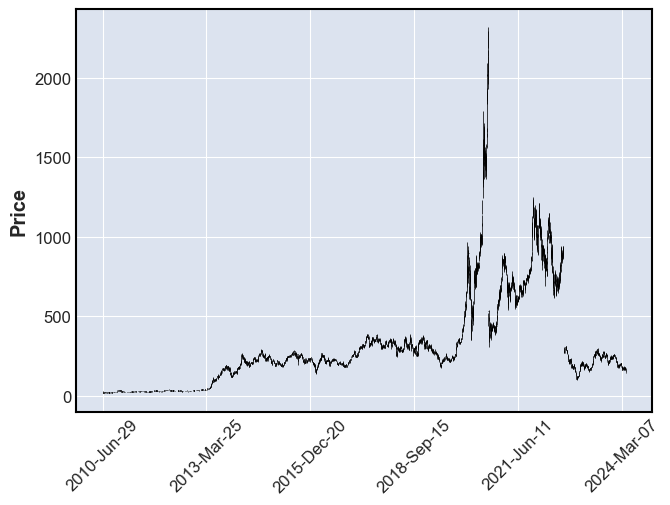

In [9]:
daily = bars.resample('1D').agg({'open': 'first', 
                                 'high': 'max', 
                                 'low': 'min', 
                                 'close': 'last'})
mpf.plot(daily, type='ohlc', show_nontrading=False, warn_too_much_data=1000000)

In [10]:
bars['date'] = bars.index.date
bars = bars.merge(splits, left_on='date', right_index=True, how='left')
bars[['open', 'high', 'low', 'close']] = bars[['open', 'high', 'low', 'close']].\
    multiply(bars["cumulative_adjustment"], axis="index")
bars['close_original'] = bars['close']

bars['turnover'] = bars['volume'] * bars['close_original']

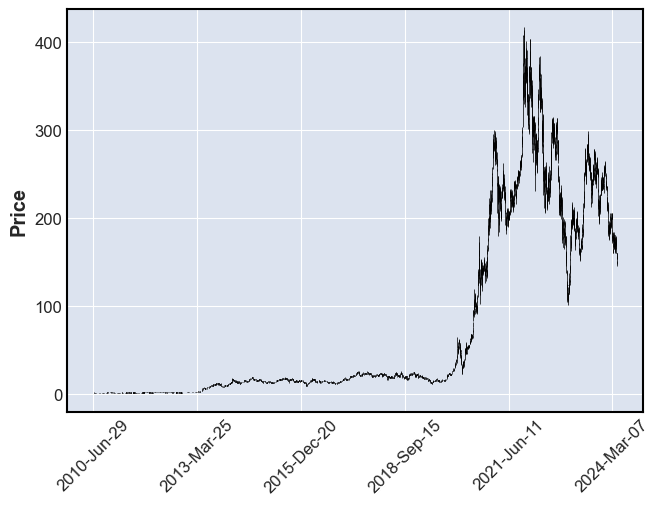

In [11]:
daily = bars.resample('1D').agg({'open': 'first', 
                                 'high': 'max', 
                                 'low': 'min', 
                                 'close': 'last'})
mpf.plot(daily, type='ohlc', show_nontrading=False, warn_too_much_data=1000000)

Putting it all together in a function yields:

In [3]:
def split_adjust(bars, ticker):
    """
    Returns the split-adjusted bars and add a column with the original close price.,
    If there is no split-data, the original bars are returned.
    """
    bars['close_original'] = bars['close']
    bars['turnover'] = bars['volume'] * bars['close_original']

    """
    ERROR FIX: When a ticker gets renamed, some (but not all) stock splits also get renamed.
    E.g. CHFS changed to NUWE after 2020-10-19, however CHFS had a 30-1 split on 2020-10-19.
    However the polygon adjustments show a 30-1 split on NUWE, not CHFS... However this is not
    true for ALL renamed tickers. E.g. for ERNA it is correct. In order to fix this, we need
    to get the ticker change which we only discuss in a future notebook. So if you have no
    ticker_changes, you can comment the two blocks of lines with # ERROR FIX out
    """
    # ERROR FIX
    ticker_changes = pd.read_csv(DATA_PATH + "../stockanalysis/ticker_changes.csv")
    has_ticker_change = False
    if len(ticker_changes[ticker_changes['from'] == ticker]['to']) != 0:
        ticker_to = ticker_changes[ticker_changes['from'] == ticker]['to'].values[0]
        has_ticker_change = True

    splits = pd.DataFrame()
    trading_dates_ticker = sorted(list(set(bars.index.date)))
    if os.path.isfile(DATA_PATH + f"raw/adjustments/{ticker}.csv"):
        adjustments = pd.read_csv(DATA_PATH + f"raw/adjustments/{ticker}.csv", parse_dates=True, index_col=0)
        adjustments.index = pd.to_datetime(adjustments.index).date
        adjustments = adjustments[(adjustments.index > trading_dates_ticker[0]) & (adjustments.index <= trading_dates_ticker[-1])]

        splits = adjustments[adjustments.type == "SPLIT"].copy()

    # ERROR FIX 
    if has_ticker_change and os.path.isfile(DATA_PATH + f"raw/adjustments/{ticker_to}.csv"):
        adjustments_to = pd.read_csv(DATA_PATH + f"raw/adjustments/{ticker_to}.csv", parse_dates=True, index_col=0)
        adjustments_to.index = pd.to_datetime(adjustments_to.index).date
        adjustments_to = adjustments_to[(adjustments_to.index > trading_dates_ticker[0]) & (adjustments_to.index <= trading_dates_ticker[-1])]
        splits_to = adjustments_to[adjustments_to.type == "SPLIT"].copy()
        splits = pd.concat([splits, splits_to])
        splits = splits.drop_duplicates()

    # Adjust for splits
    if not splits.empty:
        splits['cumulative_adjustment'] = splits['amount'][::-1].cumprod()
        splits = splits.drop(columns=['type', 'subtype', 'amount'])
        splits.index = splits.index.map(lambda day : max(d for d in trading_dates_ticker if d < day))
        splits = splits.reindex(trading_dates_ticker) # Reindex using stock data 
        splits.cumulative_adjustment = splits.cumulative_adjustment.fillna(method='bfill').fillna(value=1) 

        # Merge adjustments with the bars and adjust
        bars['date'] = bars.index.date
        bars = bars.merge(splits, left_on='date', right_index=True, how='left')
        bars['close_original'] = bars['close']
        bars[['open', 'high', 'low', 'close']] = bars[['open', 'high', 'low', 'close']].\
            multiply(bars["cumulative_adjustment"], axis="index")

        bars.drop(columns=['cumulative_adjustment', 'date'], inplace=True)

    return bars[['open', 'high', 'low', 'close', 'close_original', 'turnover']]

# 7.3 Dividend adjustment
We use the [stockcharts](https://support.stockcharts.com/doku.php?id=policies:historical_price_data_is_adjusted_for_splits_dividends_and_distributions#:~:text=Dividend%20Adjustment%20Calculation%20Details%3A,then%20multiplied%20by%20this%20factor) or [Yahoo](https://help.yahoo.com/kb/SLN28256.html) method to adjust dividends, which mimics dividend reinvesting at the close of cum-dividend date. If at cum-dividend the price is 60, and at ex-dividend is 50 after a 10/share dividend, then all prices from cum-dividend and before are adjusted by the factor *1 - (dividend/cumdividend close)*. So the adjusted cum-dividend close will be 50. 

Note: Even though the close (which can differ on early close days) is used to calculate the adjustment factor, the post-market prices also have to be adjusted. 

In [14]:
split_adjusted_bars = split_adjust(pd.read_parquet(DATA_PATH + f"raw/m1/BIL.parquet"), 'BIL')
trading_dates_ticker = sorted(list(set(bars.index.date)))

adjustments = pd.read_csv(DATA_PATH + f"raw/adjustments/BIL.csv", parse_dates=True, index_col=0)
adjustments.index = pd.to_datetime(adjustments.index).date
adjustments = adjustments[(adjustments.index > trading_dates_ticker[0]) & (adjustments.index <= trading_dates_ticker[-1])]

split_adjusted_dividends = adjustments[adjustments.type == "DIV"].copy()
split_adjusted_dividends.head(3)

C:\Users\Nathan\AppData\Local\Temp\ipykernel_17184\2070024.py:48: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  splits.cumulative_adjustment = splits.cumulative_adjustment.fillna(method='bfill').fillna(value=1)


,type,subtype,amount
2011-12-28,DIV,CD,0.001893
2014-03-03,DIV,CD,0.000000
2016-12-01,DIV,CD,0.021036


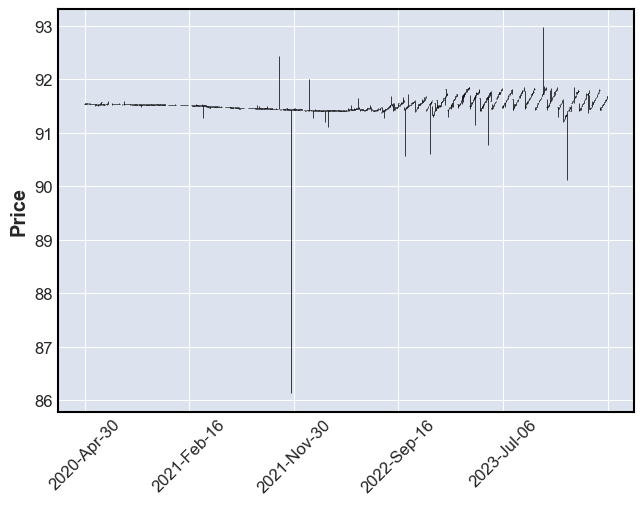

In [28]:
daily = split_adjusted_bars.resample('1D').agg({'open': 'first', 
                                 'high': 'max', 
                                 'low': 'min', 
                                 'close': 'last'})
daily.dropna(inplace=True)
mpf.plot(daily.tail(1000), type='ohlc', show_nontrading=False, warn_too_much_data=1000000)

Let's first get the cum_div_dates.

In [16]:
split_adjusted_dividends['cum_div_date'] = split_adjusted_dividends.index.map(\
    lambda day : max(d for d in trading_dates_ticker if d < day))
split_adjusted_dividends = split_adjusted_dividends[['amount', 'cum_div_date']]
split_adjusted_dividends.index.names = ['ex_div_date']
split_adjusted_dividends.head(3)

,amount,cum_div_date
ex_div_date,,
2011-12-28,0.001893,2011-12-27
2014-03-03,0.000000,2014-02-28
2016-12-01,0.021036,2016-11-30


In [17]:
# We need to get the ex-dividend closing price. Most days this is on 16:00 ET. Some days have early closes.
market_hours = get_market_calendar('datetime')
market_hours = market_hours[['regular_close']]

In [18]:
split_adjusted_dividends.set_index(split_adjusted_dividends['cum_div_date'], inplace=True)
split_adjusted_dividends['cum_div_datetime'] = market_hours.loc[split_adjusted_dividends.index, 'regular_close']

# Sometimes the latest trade of the day is NOT the 15:59 bar exactly. 
# So we need to get the latest available price at or before the close.
split_adjusted_dividends['cum_div_datetime'] = split_adjusted_dividends['cum_div_datetime'].apply(\
    lambda dt : (split_adjusted_bars[split_adjusted_bars.index <= dt].index).max())
split_adjusted_dividends.set_index(split_adjusted_dividends['cum_div_datetime'], inplace=True)
split_adjusted_dividends['cum_div_close'] = split_adjusted_bars.loc[split_adjusted_dividends['cum_div_datetime'], 'close']

In [19]:
split_adjusted_dividends.head(3)

,amount,cum_div_date,cum_div_datetime,cum_div_close
cum_div_datetime,,,,
2011-12-27 15:59:00,0.001893,2011-12-27,2011-12-27 15:59:00,91.66
2014-02-28 15:59:00,0.000000,2014-02-28,2014-02-28 15:59:00,91.54
2016-11-30 15:59:00,0.021036,2016-11-30,2016-11-30 15:59:00,91.46


In [20]:
split_adjusted_dividends['adjustment'] = 1 - (split_adjusted_dividends['amount'] / split_adjusted_dividends['cum_div_close'])
split_adjusted_dividends['cumulative_adjustment'] = split_adjusted_dividends['adjustment'][::-1].cumprod()

In [21]:
split_adjusted_dividends.head(3)

,amount,cum_div_date,cum_div_datetime,cum_div_close,adjustment,cumulative_adjustment
cum_div_datetime,,,,,,
2011-12-27 15:59:00,0.001893,2011-12-27,2011-12-27 15:59:00,91.66,0.999979,0.887138
2014-02-28 15:59:00,0.000000,2014-02-28,2014-02-28 15:59:00,91.54,1.000000,0.887156
2016-11-30 15:59:00,0.021036,2016-11-30,2016-11-30 15:59:00,91.46,0.999770,0.887156


In [22]:
split_adjusted_dividends.set_index(split_adjusted_dividends['cum_div_date'], inplace=True, drop=True)
dividend_adjustments = split_adjusted_dividends[['cumulative_adjustment']]

# Get dividend adjustments for every trading day (same procedure as split adjustments)
dividend_adjustments = dividend_adjustments.reindex(trading_dates_ticker) # Reindex using stock data 
dividend_adjustments['cumulative_adjustment'] = dividend_adjustments['cumulative_adjustment'].fillna(method='bfill').fillna(value=1) # Backward fill and fill ones

C:\Users\Nathan\AppData\Local\Temp\ipykernel_17184\3340914998.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dividend_adjustments['cumulative_adjustment'] = dividend_adjustments['cumulative_adjustment'].fillna(method='bfill').fillna(value=1) # Backward fill and fill ones


In [23]:
dividend_adjustments.head(3)

,cumulative_adjustment
cum_div_date,
2010-06-29,0.887138
2010-06-30,0.887138
2010-07-01,0.887138


In [24]:
# Same procedure as with split adjustments
all_adjusted_bars = split_adjusted_bars.copy()
all_adjusted_bars['date'] = all_adjusted_bars.index.date
all_adjusted_bars = all_adjusted_bars.merge(dividend_adjustments, left_on='date', right_index=True, how='left')
all_adjusted_bars[['open', 'high', 'low', 'close']] = all_adjusted_bars[['open', 'high', 'low', 'close']].\
    multiply(all_adjusted_bars["cumulative_adjustment"], axis="index")
all_adjusted_bars.drop(columns=['cumulative_adjustment', 'date'], inplace=True)

# Round to 4 decimals
all_adjusted_bars = round(all_adjusted_bars, 4)

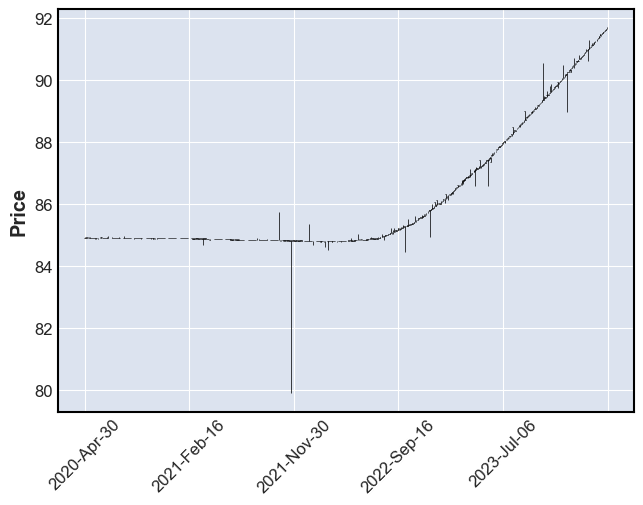

In [27]:
daily = all_adjusted_bars.resample('1D').agg({'open': 'first', 
                                 'high': 'max', 
                                 'low': 'min', 
                                 'close': 'last'})
daily.dropna(inplace=True)
mpf.plot(daily.tail(1000), type='ohlc', show_nontrading=False, warn_too_much_data=1000000)

Putting it all in a function yields:

In [4]:
def div_adjust(split_adjusted_bars, ticker):
    """
    Dividend-adjust the 1-minute bars.
    """
    if os.path.isfile(DATA_PATH + f"raw/adjustments/{ticker}.csv"):
        trading_dates_ticker = sorted(list(set(split_adjusted_bars.index.date)))

        adjustments = pd.read_csv(DATA_PATH + f"raw/adjustments/{ticker}.csv", parse_dates=True, index_col=0)
        adjustments.index = pd.to_datetime(adjustments.index).date
        adjustments = adjustments[(adjustments.index > trading_dates_ticker[0]) & \
                                    (adjustments.index <= trading_dates_ticker[-1])]
        split_adjusted_dividends = adjustments[adjustments.type == "DIV"].copy()
        all_adjusted_bars = split_adjusted_bars.copy()

        if not split_adjusted_dividends.empty:
            # Get cum div date
            split_adjusted_dividends['cum_div_date'] = split_adjusted_dividends.index.map(\
                lambda day : max(d for d in trading_dates_ticker if d < day))
            
            split_adjusted_dividends = split_adjusted_dividends[['amount', 'cum_div_date']]
            split_adjusted_dividends.index.names = ['ex_div_date']

            # We need to get the ex-dividend closing price. Most days this is on 16:00 ET. Some days have early closes.
            market_hours = get_market_calendar('datetime')
            market_hours = market_hours[['regular_close']]

            split_adjusted_dividends.set_index(split_adjusted_dividends['cum_div_date'], inplace=True)
            split_adjusted_dividends['cum_div_datetime'] = market_hours.loc[split_adjusted_dividends.index, 'regular_close']

            # Sometimes the latest trade of the day is NOT the 15:59 bar exactly. 
            # So we need to get the latest available price at or before the close.
            split_adjusted_dividends['cum_div_datetime'] = split_adjusted_dividends['cum_div_datetime'].apply(\
                lambda dt : (split_adjusted_bars[split_adjusted_bars.index <= dt].index).max())
            split_adjusted_dividends.set_index(split_adjusted_dividends['cum_div_datetime'], inplace=True)
            split_adjusted_dividends['cum_div_close'] = split_adjusted_bars.loc[split_adjusted_dividends['cum_div_datetime'], 'close']

            # Calculate adjustments
            split_adjusted_dividends['adjustment'] = 1 - (split_adjusted_dividends['amount'] / split_adjusted_dividends['cum_div_close'])
            split_adjusted_dividends['cumulative_adjustment'] = split_adjusted_dividends['adjustment'][::-1].cumprod()

            split_adjusted_dividends.set_index(split_adjusted_dividends['cum_div_date'], inplace=True, drop=True)
            dividend_adjustments = split_adjusted_dividends[['cumulative_adjustment']]

            dividend_adjustments = dividend_adjustments.reindex(trading_dates_ticker) # Reindex using stock data 
            dividend_adjustments['cumulative_adjustment'] = dividend_adjustments['cumulative_adjustment'].\
                fillna(method='bfill').fillna(value=1) # Backward fill and fill ones

            # Same procedure as with split adjustments
            all_adjusted_bars['date'] = all_adjusted_bars.index.date
            all_adjusted_bars = all_adjusted_bars.merge(dividend_adjustments, left_on='date', right_index=True, how='left')
            all_adjusted_bars[['open', 'high', 'low', 'close']] = all_adjusted_bars[['open', 'high', 'low', 'close']].\
                multiply(all_adjusted_bars["cumulative_adjustment"], axis="index")

            all_adjusted_bars.drop(columns=['cumulative_adjustment', 'date'], inplace=True)
    else:
        all_adjusted_bars = split_adjusted_bars.copy()
    # Round to 4 decimals
    return round(all_adjusted_bars, 4)

# 7.4 Reindexing and NA values

When reindexing we need to get a list of all minutes. Since we will also have to do this in the backtester (which loops over the minutes), we will store it and create a function to retrieve it.

In [30]:
###
market_hours = get_market_calendar()

# Get all minutes from trading days
trading_datetimes = pd.date_range(start=market_hours.index[0], \
                                  end=datetime.combine(market_hours.index[-1], time(23, 59)), freq='min', name='datetime')
trading_datetimes[(trading_datetimes.time >= time(4, 0)) & (trading_datetimes.time <= time(19, 59))]

# Filter to all trading minutes in trading days
trading_datetimes = trading_datetimes[trading_datetimes.to_series().dt.date.isin(market_hours.index)]
trading_datetimes = trading_datetimes[(trading_datetimes.time >= time(4)) & (trading_datetimes.time <= time(19, 59))] 

# Remove the minutes in early closes (from 17:00 to 19:59 there is no post-market on early close days)
early_closes = market_hours[market_hours['postmarket_close'] != time(19, 59)]
for day, early_close in early_closes.iterrows():
    postmarket_close = early_close['postmarket_close']
    trading_datetimes = trading_datetimes[~((trading_datetimes > datetime.combine(day, early_close['postmarket_close'])) \
                                            & (trading_datetimes <= datetime.combine(day, time(19, 59)) ) )] 

pd.DataFrame(index=trading_datetimes).to_parquet(DATA_PATH + 'market/trading_minutes.parquet')

In [5]:
from functools import lru_cache

# This decorator ensures that when we call a function the output is stored for future calls.
# This is useful if executing the function is expensive and gets called a lot.
@lru_cache
def get_market_minutes():
    trading_datetimes = pd.read_parquet(DATA_PATH + 'market/trading_minutes.parquet')
    return pd.to_datetime(trading_datetimes.index)

In [6]:
def reindex_and_fill(bars):
    # Get the days the ticker is trading
    ticker_days = sorted(list(set(bars.index.date)))
    market_datetimes = get_market_minutes()
    ticker_datetimes = market_datetimes[(market_datetimes.date >= ticker_days[0]) & (market_datetimes.date <= ticker_days[-1])]

    # Reindex
    bars = bars.reindex(ticker_datetimes)

    # Fill NA values
    bars['tradeable'] = ~bars['turnover'].isna()
    bars['turnover'] = bars['turnover'].fillna(value=0) 

    bars["close"] = bars["close"].fillna(method="ffill")
    bars["close_original"] = bars["close_original"].fillna(method="ffill")
    bars["open"] = bars["open"].fillna(bars["close"])
    bars["low"] = bars["low"].fillna(bars["close"])
    bars["high"] = bars["high"].fillna(bars["close"])

    # Only affects the very start. Else backfill shouldn't be used because of look-ahead bias.
    bars["open"] = bars["open"].fillna(method="bfill")
    
    bars["close"] = bars["close"].fillna(bars["open"])
    bars["close_original"] = bars["close_original"].fillna(method='bfill') # Technically we should get the open_original, but I am not going to bother with the untradeable bars at the start that will never be used.
    bars["low"] = bars["low"].fillna(bars["open"])
    bars["high"] = bars["high"].fillna(bars["open"])
    
    return bars

In [35]:
bars = pd.read_parquet(f"{DATA_PATH}raw/m1/BIL.parquet")
split_adjusted_bars = split_adjust(bars, "BIL")
all_adjusted_bars = div_adjust(split_adjusted_bars, "BIL")
reindex_and_fill(all_adjusted_bars).head(3)

,open,high,low,close,close_original,turnover,tradeable
datetime,,,,,,,
2007-05-30 04:00:00,79.8984,79.8984,79.8984,79.8984,45.79,0.0,False
2007-05-30 04:01:00,79.8984,79.8984,79.8984,79.8984,45.79,0.0,False
2007-05-30 04:02:00,79.8984,79.8984,79.8984,79.8984,45.79,0.0,False


# 7.5 Putting it all in a loop
Later on, I got an error which was caused by stock prices being negative. This is caused by some special events (with a dividend type of 'SC'), where Polygon has already adjusted for it... We avoid this problem by manually deleting the dividend/split in the adjustment:
* GEN: 2020-02-03
* LIAN: 2024-02-26
* BBVA: 2014-12-17 (split)
* IRSA: the dividends are NOT split adjusted. Split adjust manually.
* KELYB: remove the 2015-05-14 dividend and add it to the dividend before. This ticker has almost no data. Same with 2018-05-21.
* KGC: remove the 2004-12-05 and 2004-12-06 split.
* SFE: remove the 2024-01-16 split. Apparently sometimes companies do a 100-to-1 and 1-to-100 at the same time to weed out shareholders that have less than 100 shares in some rare scenarios. When one of the two misses, we may get very incorrect prices.
* SPC: I have no idea what happened here. The stock price from 2005-2008 went from 40 to 0. No stock splits found. The ticker went delisted and then came back as SPB. However when looking at the TradingView charts, the price didn't seem to move much. I also couldn't find any dividends in the period 2005-2008 online. I will simply delete the dividend file.


In [10]:
tickers_v3 = get_tickers(v=3)
for index, row in tickers_v3.iterrows():
    id = row['ID']
    ticker = row["ticker"]
    start_date = row['start_date']
    end_date = row['end_date']

    try:
        dataset = pq.ParquetDataset(
            DATA_PATH + f"raw/m1/{ticker}.parquet",
            filters=[
                ("datetime", ">=", datetime.combine(start_date, time(4))),
                ("datetime", "<=", datetime.combine(end_date, time(20))),
            ],
        )
    except FileNotFoundError:
        #print(f"There is no data for {id}")
        continue

    bars = dataset.read().to_pandas()
    if bars.empty:
        #print(f"There is no data for {id}")
        continue

    # ADJUSTING
    split_adjusted_bars = split_adjust(bars, ticker)
    all_adjusted = div_adjust(split_adjusted_bars, ticker)

    # FORWARD FILLING
    all_adjusted = reindex_and_fill(all_adjusted)

    # ROUNDING: TO 4 DECIMALS, TURNOVER TO INT
    all_adjusted = round(all_adjusted, 4)
    all_adjusted['turnover'] = all_adjusted['turnover'].astype(int)

    if (all_adjusted['close'] < 0).any():
        print(f'{id} has negative prices!')
        #raise Exception(f'{id} has negative prices!')
    
    all_adjusted.to_parquet(DATA_PATH + f"processed/m1/{id}.parquet", engine="fastparquet", row_group_offsets=25000)

# 7.6 Updating the ticker list
Now that we have the data, we can add two columns <code>start_data</code> and <code>end_data</code>.

In [3]:
import pyarrow.parquet as pq

tickers_v3 = get_tickers(v=3)
tickers_v3["start_data"] = np.nan
tickers_v3["end_data"] = np.nan

for index, row in tickers_v3.iterrows():
    id = row['ID']
    try:
        dataset = pq.ParquetFile(DATA_PATH + f"processed/m1/{id}.parquet")
    except FileNotFoundError:
        #print(f"There is no data for {id}")
        continue

    # Reading metadata (statistics) of first and last row group. This avoids reading the entire file.
    # Reading everything from the datetime column and getting first/last row took 8 minutes. This took less than 50 sec.
    metadata_first_row_group = dataset.metadata.row_group(0)
    metadata_last_row_group = dataset.metadata.row_group(dataset.num_row_groups-1)
    # Retrieve statistics
    min_date = metadata_first_row_group.column(0).statistics.min
    max_date = metadata_last_row_group.column(0).statistics.max
    # Convert to date
    start_data = min_date.to_pydatetime().date()
    end_data = max_date.to_pydatetime().date()
    
    tickers_v3.loc[tickers_v3['ID'] == id, ["start_data", "end_data"] ] = [start_data, end_data]
    
tickers_v3.reset_index(inplace=True)
tickers_v3[["ID", "ticker", "name", "active", "start_date", "end_date", "start_data", "end_data", "type", "cik", "composite_figi"]].to_csv("../data/tickers_v4.csv")

In [4]:
tickers_v4 = get_tickers(v=4)
tickers_v4['start_data'] = pd.to_datetime(tickers_v4['start_data']).dt.date
tickers_v4['end_data'] = pd.to_datetime(tickers_v4['end_data']).dt.date
tickers_v4.iloc[:3, :9].head(3)

,ID,ticker,name,active,start_date,end_date,start_data,end_data,type
0,A-2003-09-10,A,"AGILENT TECHNOLOGIES, INC",False,2003-09-10,2005-11-22,2003-09-10,2005-11-22,CS
1,A-2005-12-14,A,Agilent Technologies Inc.,True,2005-12-14,2024-04-19,2005-12-14,2024-04-19,CS
2,AA-2003-09-10,AA,Alcoa Corporation,True,2003-09-10,2024-04-19,2003-09-10,2024-04-19,CS


Some stocks have zero data. There are the tickers with only ghost days. We can safely remove those.

In [5]:
zero_data = tickers_v4[tickers_v4['start_data'].isna()]
print(len(zero_data))
zero_data.iloc[:3, :9].head(3)

282


,ID,ticker,name,active,start_date,end_date,start_data,end_data,type
4,AAAA-2007-10-31,AAAA,ALTAS INDUSRIES HOLDINGS LLC COM,False,2007-10-31,2007-11-29,NaT,NaT,CS
5,AAAP-2015-02-04,AAAP,ADVANCED ACCELERATOR APPLICATIONS S A SPONSORE...,False,2015-02-04,2015-02-05,NaT,NaT,ADRC
113,ABPI-2005-07-01,ABPI,"ACCENTIA BIOPHARMACEUTICALS, INC.",False,2005-07-01,2005-07-22,NaT,NaT,CS


In [6]:
tickers_v4 = tickers_v4[~(tickers_v4['start_data'].isna() & (tickers_v4['type'] != "INDEX"))]
tickers_v4.reset_index(inplace=True, drop=True)
tickers_v4.to_csv("../data/tickers_v4.csv")

# 7.7 Updates
- Load the functions
- Update trading_minutes
- Put everything in m1_renamed to m1, to reverse renamings.
- Run below cells.
- Run 7.6

Loop through v3:
- If the ID is in the (old) <code>tickers_v4</code> and <code>end_date</code>(v3) is larger than the old_END_DATE (v4), then we know this is a ticker that kept its listing. Do the processing on the new part only. However we must not forget that adjustments carry over to the old data. If in the new data there is a 100:1 split, all old data has to be multiplied with 100x. (Adjustments are really annoying. Dividends and splits should just be banned. Brokers should just quote in 10e-6 for stocks that dilute to infinity. Dividends can be perfectly replaced with share buybacks.)
- If the ID is not in <code>tickers_v4</code> AND start_date (v3) is larger than old_END_DATE, it's a new listing. Do the processing on the entire file.

In [7]:
from times import first_trading_date_after
from fastparquet import write
import pyarrow.parquet as pq

In [8]:
old_tickers_v4 = pd.read_csv("../data/tickers_v4_OLD.csv", index_col=0)
old_tickers_v4 = old_tickers_v4[old_tickers_v4['type'].isin(['CS', 'ADRC', 'ETN', 'ETV', 'ETF'])]
old_END_DATE = date.fromisoformat(old_tickers_v4['end_date'].max())
old_IDs = list(old_tickers_v4['ID'])

process_from_dt = datetime.combine(first_trading_date_after(old_END_DATE), time(4))

In [12]:
tickers_v3 = get_tickers(v=3, types=["CS", "ADRC", "ETF", "ETN", "ETV"])

for index, row in tickers_v3.iterrows():
    id = row["ID"]
    ticker = row["ticker"]
    start_date = row["start_date"]
    end_date = row["end_date"]

    if id in old_IDs and end_date > old_END_DATE:
        try:
            dataset = pq.ParquetDataset(
            DATA_PATH + f"raw/m1/{id}.parquet", filters=[("datetime", ">=", process_from_dt)])
        except FileNotFoundError:
            print(f"There is no data for {id}")
            continue

        bars = dataset.read().to_pandas()

        if bars.empty:
            continue

        # ADJUSTING
        split_adjusted_bars = split_adjust(bars, ticker)
        all_adjusted = div_adjust(split_adjusted_bars, ticker)

        # FORWARD FILLING
        all_adjusted = reindex_and_fill(all_adjusted)

        # ROUNDING: TO 4 DECIMALS, TURNOVER TO INT
        all_adjusted = round(all_adjusted, 4)
        all_adjusted['turnover'] = all_adjusted['turnover'].astype(int)

        if (all_adjusted['close'] < 0).any():
            raise Exception(f'{id} has negative prices!')

        # Of course, an adjustment can take place on exactly the boundary.
        has_adjustments = False
        if os.path.isfile(DATA_PATH + f"raw/adjustments/{ticker}.csv"):
            adjustments = pd.read_csv(DATA_PATH + f"raw/adjustments/{ticker}.csv", parse_dates=True, index_col=0)
            adjustments.index = pd.to_datetime(adjustments.index).date
            adjustments = adjustments[(adjustments.index == first_trading_date_after(old_END_DATE))]
            has_adjustments = True

        # Adjustment need to carry over, however we first process the adjustments on the boundary.
        new_bars_first_bar = all_adjusted.iloc[0]
        adjustment_factor = new_bars_first_bar['close'] / new_bars_first_bar['close_original']
        if has_adjustments or adjustment_factor != 1:
            old_bars = pd.read_parquet(DATA_PATH + f"processed/m1/{id}.parquet")

        if has_adjustments:
            # SPLIT ADJUSTMENT
            split = adjustments[adjustments.type == 'SPLIT']
            if len(split) > 0:
                split_amount = split['amount'][0]
                old_bars[['open', 'high', 'low', 'close']] = old_bars[['open', 'high', 'low', 'close']].multiply(split_amount)

            # DIVIDEND ADJUSTMENT - REUN is the only case, not clear what happened there, likely a 'special dividend'
            dividend = adjustments[adjustments.type == 'DIV']
            if len(dividend) > 0:
                market_hours = get_market_calendar()
                market_hours = market_hours[['regular_close']]

                cum_div_date = old_END_DATE
                cum_div_time = market_hours.loc[cum_div_date][0]
                cum_div_datetime = datetime.combine(cum_div_date, cum_div_time)
                cum_div_datetime = (old_bars[old_bars.index <= cum_div_datetime].index).max()
                cum_div_close = old_bars.loc[cum_div_datetime, 'close']
                dividend_amount = dividend['amount'][0]
                    
                adjustment_factor = 1 - dividend_amount/cum_div_close

                old_bars[['open', 'high', 'low', 'close']] = old_bars[['open', 'high', 'low', 'close']].multiply(adjustment_factor)

            # ROUNDING
            if len(split) > 0 or len(dividend) > 0:
                old_bars = round(old_bars, 4)
                old_bars['turnover'] = old_bars['turnover'].astype(int)

        # New adjustments carry over to old data...
        new_bars_first_bar = all_adjusted.iloc[0]
        adjustment_factor = new_bars_first_bar['close'] / new_bars_first_bar['close_original']

        if adjustment_factor != 1:
            old_bars[['open', 'high', 'low', 'close']] = old_bars[['open', 'high', 'low', 'close']].multiply(adjustment_factor)
            old_bars = round(old_bars, 4)
        
        if has_adjustments or adjustment_factor != 1:
            all_bars = pd.concat([old_bars, all_adjusted])
            # Because not all stocks trade on all days, there may be a gap between the old and new bars. We have to refill them.
            reindex_and_fill(all_bars).to_parquet(DATA_PATH + f"processed/m1/{id}.parquet", engine="fastparquet", row_group_offsets=25000)
        else:
            write(DATA_PATH + f"processed/m1/{id}.parquet", all_adjusted, append=True)

    elif id not in old_IDs and start_date > old_END_DATE:
        try:
            bars = pd.read_parquet(f"{DATA_PATH}raw/m1/{id}.parquet")
        except FileNotFoundError:
            print(f"There is no data for {id}")
            continue

        # ADJUSTING
        split_adjusted_bars = split_adjust(bars, ticker)
        all_adjusted = div_adjust(split_adjusted_bars, ticker)

        # FORWARD FILLING
        all_adjusted = reindex_and_fill(all_adjusted)

        # ROUNDING: TO 4 DECIMALS, TURNOVER TO INT
        all_adjusted = round(all_adjusted, 4)
        all_adjusted['turnover'] = all_adjusted['turnover'].astype(int)

        if (all_adjusted['close'] < 0).any():
            raise Exception(f'{id} has negative prices!')
        
        all_adjusted.to_parquet(DATA_PATH + f"processed/m1/{id}.parquet", engine="fastparquet", row_group_offsets=25000)


In [ ]:
# all_files = os.listdir(DATA_PATH + f'raw/adjustments/')
# for index, file in enumerate(all_files):
#     adjustments = pd.read_csv(DATA_PATH + f'raw/adjustments/{file}')
#     if not adjustments[adjustments['type'] == 'DIV'].empty:
#         dividends = adjustments[adjustments['type'] == 'DIV']
#         indices_to_remove = dividends[dividends[['date', 'type']].duplicated(keep='last')].index
#         adjustments = adjustments.drop(index=indices_to_remove)
#     if not adjustments[adjustments['type'] == 'SPLIT'].empty:
#         splits = adjustments[adjustments['type'] == 'SPLIT']
#         indices_to_remove = splits[splits[['date', 'type']].duplicated(keep='last')].index
#         adjustments = adjustments.drop(index=indices_to_remove)
#     adjustments.to_csv(DATA_PATH + f'raw/adjustments/{file}', index=False)